# Introduction

This notebook trains a linear discriminant analysis model on preprocessed EEG data to predict behavioral data from neural features.

An example of this can be found in the paper, "Human stereoEEG recordings reveal network dynamics of decision-making in a rule-switching task" by Wal et al.

Behavioral data and preprocessed neural data from Subject 06 in the NCSL EFRI datasetwill be used in this notebook.

## Imports

In [1]:
import h5py 
import mat73
import numpy as np
import mne
from matplotlib import pyplot as plt
from sklearn.model_selection import RepeatedKFold, cross_validate
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.stats import ttest_1samp

## Load File Paths

In [2]:
# ncsl_share = '/run/user/1000/gvfs/smb-share:server=10.162.37.21,share=main'
# data_path = f'Data/Subject06_snapshot_normalized.npy'
ncsl_share = '/mnt/ncsl_share'
data_path = ncsl_share + f'/Daniel/Data/Trial_by_Chan_by_Freq_by_Time_Snapshots/Subject06_snapshot_normalized.npy'
setup_path = ncsl_share + f'/Public/EFRI/1_formatted/SUBJECT06/EFRI06_WAR_SES1_Setup.mat'
raw_path = ncsl_share + f'/Public/EFRI/1_formatted/SUBJECT06/EFRI06_WAR_SES1_Raw.mat'
out_path_tvalues = f't_values'

raw_file = h5py.File(raw_path)
setup_data = mat73.loadmat(setup_path)

In [95]:
setup_data.keys()

dict_keys(['elec_area', 'elec_ind', 'elec_name', 'filters', 'trial_times', 'trial_words'])

## Instantiate variables

In [3]:
bets = setup_data['filters']['bets']

good_trials = np.where(np.isnan(bets) == False)[0] # extract indices of trials without the 'nan'

bets = bets[good_trials] # get the bet values for the good trials
subject_cards = setup_data['filters']['card1'][good_trials] # get the subject's card values for the good trials

In [4]:
elec_name = setup_data['elec_name']
elec_area = setup_data['elec_area']

In [5]:
data = np.load(data_path)
num_trials, num_channels, num_freqs, num_timesteps = data.shape

In [6]:
y = np.asarray([(0 if bet == 5 else 1) for bet in bets]) # 0 = low bet ($5), 1 = high bet ($20)

## Model Training

Using the power per wavelet scale for a particular channel and timepoint as a feature. 

In [109]:
def train_LDA_model(data, y, channel, time):
    X = data[:, channel, :, time] # get the EEG data for a particular channel and time point
    high_bet_indices = np.where(y == 1)
    low_bet_indices = np.where(y == 0)
    power_diff = X[high_bet_indices, :][0].mean(0) - X[low_bet_indices, :][0].mean(0)

    '''
    # Using RepeatedKFold() for training LDA
    rkf = RepeatedKFold(n_splits=5, n_repeats=1)

    estimators = []
    scores = []

    for train, test in rkf.split(X):
        lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
        lda.fit(X[train], y[train])
        estimators.append(lda)
        scores.append(lda.score(X[test], y[test]))
    '''

    # Using cross_validate() function for training LDA
    lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
    cv_results = cross_validate(lda, X, y, cv = 5, return_estimator=True)

    estimators = cv_results['estimator']
    scores = cv_results['test_score']

    best_score = max(scores)
    best_index = list(scores).index(best_score)
    best_lda = estimators[best_index] # select the best performing model after cross-validation

    dval = np.dot(X, best_lda.coef_.T).T[0] + best_lda.intercept_ # calculate decision value 

    t_stat = ttest_1samp(dval, popmean=0).statistic # perform 1-sided t-test on decision values corresponding to high bet
    return best_score, dval, t_stat, power_diff

In [172]:
X = data[:, 0, :, 0] # get the EEG data for a particular channel and time point
high_bet_indices = np.where(y == 1)
low_bet_indices = np.where(y == 0)
power_diff = X[high_bet_indices, :][0].mean(0) - X[low_bet_indices, :][0].mean(0)

lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
cv_results = cross_validate(lda, X, y, cv = 5, return_estimator=True)

estimators = cv_results['estimator']
scores = cv_results['test_score']

best_score = max(scores)
best_index = list(scores).index(best_score)
best_lda = estimators[best_index]

dval = np.dot(X, best_lda.coef_.T).T[0] + best_lda.intercept_ # calculate decision value
y_pred = best_lda.predict(X)

t_stat = ttest_1samp(dval, popmean=0).statistic # perform 1-sided t-test on decision values corresponding to high bet
# return best_score, dval, t_stat, power_diff

In [173]:
print(dval)
print(y_pred)

[-7.19570749e-02 -2.39545076e+00 -1.89675731e+00 -1.61784272e+00
  8.65586426e-01 -2.32619497e-01 -1.70405341e+00 -1.51836345e+00
 -1.78153267e+00  5.25939260e-01  1.21401344e+00 -1.67371880e-01
 -1.24324346e+00  1.16721193e+00  1.44351275e+00 -9.99988907e-01
 -9.96880303e-01 -1.96245252e+00  9.59467576e-01 -1.85075891e-01
 -4.95450022e-01 -2.26187499e-01  4.39429560e-01 -8.54400089e-01
 -1.72543779e+00  4.07022383e-01  7.54825970e-01 -5.56563652e-01
 -7.59752342e-02 -9.63261358e-01 -1.80370787e+00 -2.63058011e-01
 -3.32710321e-03 -2.39161023e+00  9.89091137e-01  7.01258134e-01
  4.05534545e-01  3.01700718e-01 -3.16608114e-01  1.21740655e-02
 -3.96202995e+00  3.85068442e-01 -1.49295215e-01 -2.31918095e+00
 -1.70439016e-01 -1.81314316e+00  3.42420863e-02  2.46867967e-02
  9.39496786e-02 -1.67597108e-02 -5.57481381e-01 -3.86195232e-01
  6.59284688e-01  9.40353850e-01  1.54283950e+00 -7.85246790e-01
 -2.10263420e+00 -8.22725924e-02 -3.49061676e-01  3.33131051e-01
  4.45168548e-01 -3.34248

In [110]:
# Code to train LDA model for all channels and timepoints for Subject 6
dvals = np.zeros((num_channels, num_timesteps, num_trials))
t_stats = np.zeros((num_channels,num_timesteps))
best_scores = np.zeros((num_channels, num_timesteps))
power_diffs = np.zeros((num_freqs,num_timesteps))

for channel in range(num_channels):
    for time in range(num_timesteps):
        np.random.seed()
        best_scores[channel, time], dvals[:, time], t_stats[channel,time], power_diffs[:,time] = train_LDA_model(data, y, channel, time)

## Reshuffling of Data

In [8]:
# Returns an array with shuffled y-values, ensures that high bet ratio is consistent with thay expected for the particular card value

def shuffle_y(y):
    # Get the locations for each particular card value
    card_value_indices = []
    for i in [2,4,6,8,10]:
        card_value_indices.append(np.where(subject_cards == i)[0])

    y_shuffled = np.zeros(y.shape)

    # Ensure that the number of high bets in the shuffled y labels is consistent with the card value
    for indices in card_value_indices:
        temp = indices
        num_high_bets = y[indices].sum() + round(np.random.uniform(-1,1)*y[indices].sum()*0.2) # Get the number of high bets for a particular card value and add some randomness to it
        for j in range(num_high_bets):
            if np.any(temp):
                # Pick a random location from all possible locations of that particular card value and set it to 1 (ie high bet)
                rand = np.random.choice(temp)
                y_shuffled[rand] = 1
                rand_index = np.where(temp == rand)[0]
                temp = np.delete(temp,rand_index) # Remove that location from being able to be chosen again
        y_shuffled[temp] = 0 # set all other locations for that particular card value to 0 (ie low bet)

    return y_shuffled

## Multiprocessing

In [36]:
def get_LDA_bet_shuffled_outputs(data, y, num_channels, num_timesteps, num_trials):
    np.random.seed()
    best_scores = np.zeros((num_channels, num_timesteps))
    dvals = np.zeros((num_channels, num_timesteps, num_trials))
    t_stats = np.zeros((num_channels,num_timesteps))
    power_diffs = np.zeros((num_freqs, num_timesteps))
    y_shuffled = shuffle_y(y)
    
    for channel in range(num_channels):
        for time in range(num_timesteps):
          best_scores[channel,time], dvals[:,time], t_stats[channel,time], power_diffs[:,time] = train_LDA_model(data, y_shuffled, channel, time)
    
    return t_stats

In [37]:
import multiprocessing

n_processes = 2
pool = multiprocessing.Pool(processes= n_processes)
results = pool.starmap(get_shuffled_t_stats, [(data, y, num_channels, num_timesteps, num_trials)] * 2)
pool.close()

KeyboardInterrupt: 

In [10]:
sub6_shuffled_t_stats = np.load('t_values/Subject06_shuffled_tvalues.npy')

In [11]:
sub6_shuffled_t_stats.shape

(100, 133, 100)

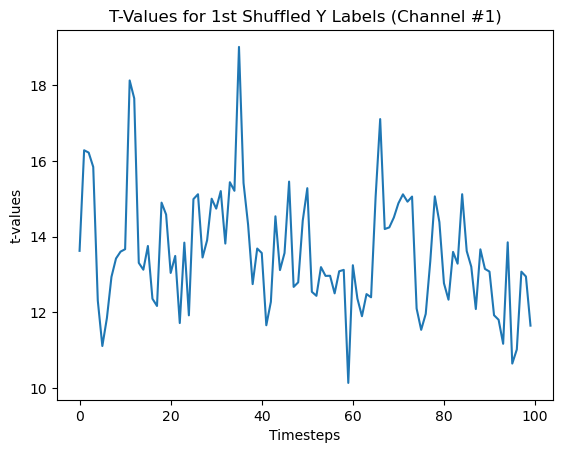

In [12]:
plt.plot(sub6_shuffled_t_stats[0][0])
plt.xlabel('Timesteps')
plt.ylabel('t-values')
plt.title('T-Values for 1st Shuffled Y Labels (Channel #1)')
plt.show()

In [13]:
sub6_t_stats = np.load('t_values/Subject06_tvalues.npy')

In [11]:
sub6_t_stats.shape

(133, 100)

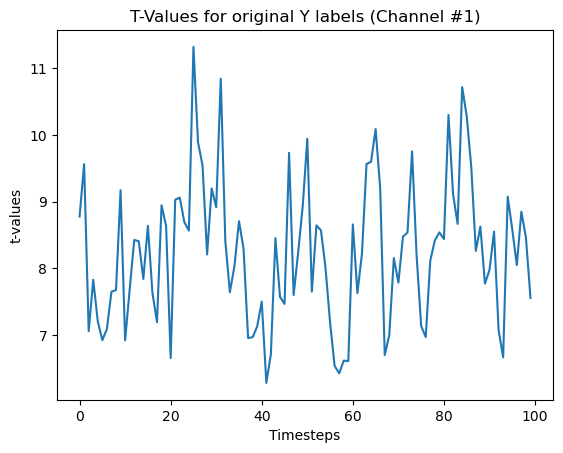

In [15]:
plt.plot(sub6_t_stats[0])
plt.xlabel('Timesteps')
plt.ylabel('t-values')
plt.title('T-Values for original Y labels (Channel #1)')
plt.show()

In [ ]:
import itertools
from joblib import Parallel, delayed


t_values = Parallel(n_jobs=-1)(delayed(get_shuffled_t_values) for i in range(1))

# Visualization of the Accuracy of the Models

In [21]:
def plot_sorted_scores(best_scores_max_sorted):
    fig, axs = plt.subplots(3, 1, figsize=(24, 18))

    axs[0].set_title('Sorted Peak Score of LDA Models (from greatest to least)')
    axs[0].set_ylabel('Peak Accuracy')
    axs[0].set_xlabel('Channels (from most to least accurate)')
    axs[0].plot(best_scores_max_sorted[:,2])

    axs[1].set_title('Sorted Peak Score of LDA Models (from greatest to least)')
    axs[1].set_ylabel('Peak Accuracy')
    axs[1].set_xlabel('Channels (from most to least accurate)')
    axs[1].bar(np.arange(0,num_channels), best_scores_max_sorted[:,2])
    axs[1].set_ylim(min(best_scores_max_sorted[:,2]) - 0.025, max(best_scores_max_sorted[:,2]) + 0.025)

    axs[2].set_title('Time of Peak Score of LDA Models')
    axs[2].set_ylabel('Time (seconds)')
    axs[2].set_xlabel('Channels (from most to least accurate)')
    time = best_scores_max_sorted[:,1]/20 -3
    axs[2].scatter(np.arange(0, num_channels), time)
    
    plt.savefig('accuracy_plots/sorted_accuracies.png')

In [30]:
# Plots the model accuracy as a function of time for the top performing channels, number of plots specified by "num_plots"
def plot_sorted_scores_per_channel(num_plots, best_scores_max_sorted):
    fig, axs = plt.subplots(num_plots, 1, figsize=(24, 6 * num_plots))

    time = (np.arange(0, 100, 1) / 20) - 3 # time 0 seconds denotes when the subject starts moving 

    for i, channel in enumerate(best_scores_max_sorted[:num_plots]):
        ch_index, timepoint, peak_accuracy = channel
        timepoint = timepoint/20 - 3
        ax = axs[i]
        ax.plot(time[:], best_scores[int(ch_index)])
        ax.set_title('Electrode %s in the %s' %(elec_name[int(ch_index)], elec_area[int(ch_index)]))
        ax.set_ylabel('Score')
        ax.set_xlabel('Time (seconds)')
        ax.axvspan(timepoint - .0025 ,timepoint + .0025, color = 'red', alpha=0.5)
        ax.annotate(f'(Time: {timepoint:.2f}s, Score: {peak_accuracy:.2f})', xy=(timepoint + .05 ,.55))
    
    plt.savefig('accuracy_plots/accuracies_line.png')

In [31]:
def plot_scores(num_channels, best_scores):
    best_scores_max = np.zeros((num_channels,3))

    for channel in range(num_channels):
        best_scores_max[channel, 0] = channel # store the channel index
        best_scores_max[channel, 1] = list(best_scores[channel]).index(max(best_scores[channel])) # the time point at which the maximum accuracy occurs
        best_scores_max[channel, 2] = max(best_scores[channel]) # value of the max score in a particular channel for all time points

    best_scores_max_sorted = best_scores_max[best_scores_max[:,2].argsort()[::-1]]

    plot_sorted_scores(best_scores_max_sorted)
    plot_sorted_scores_per_channel(10, best_scores_max_sorted)

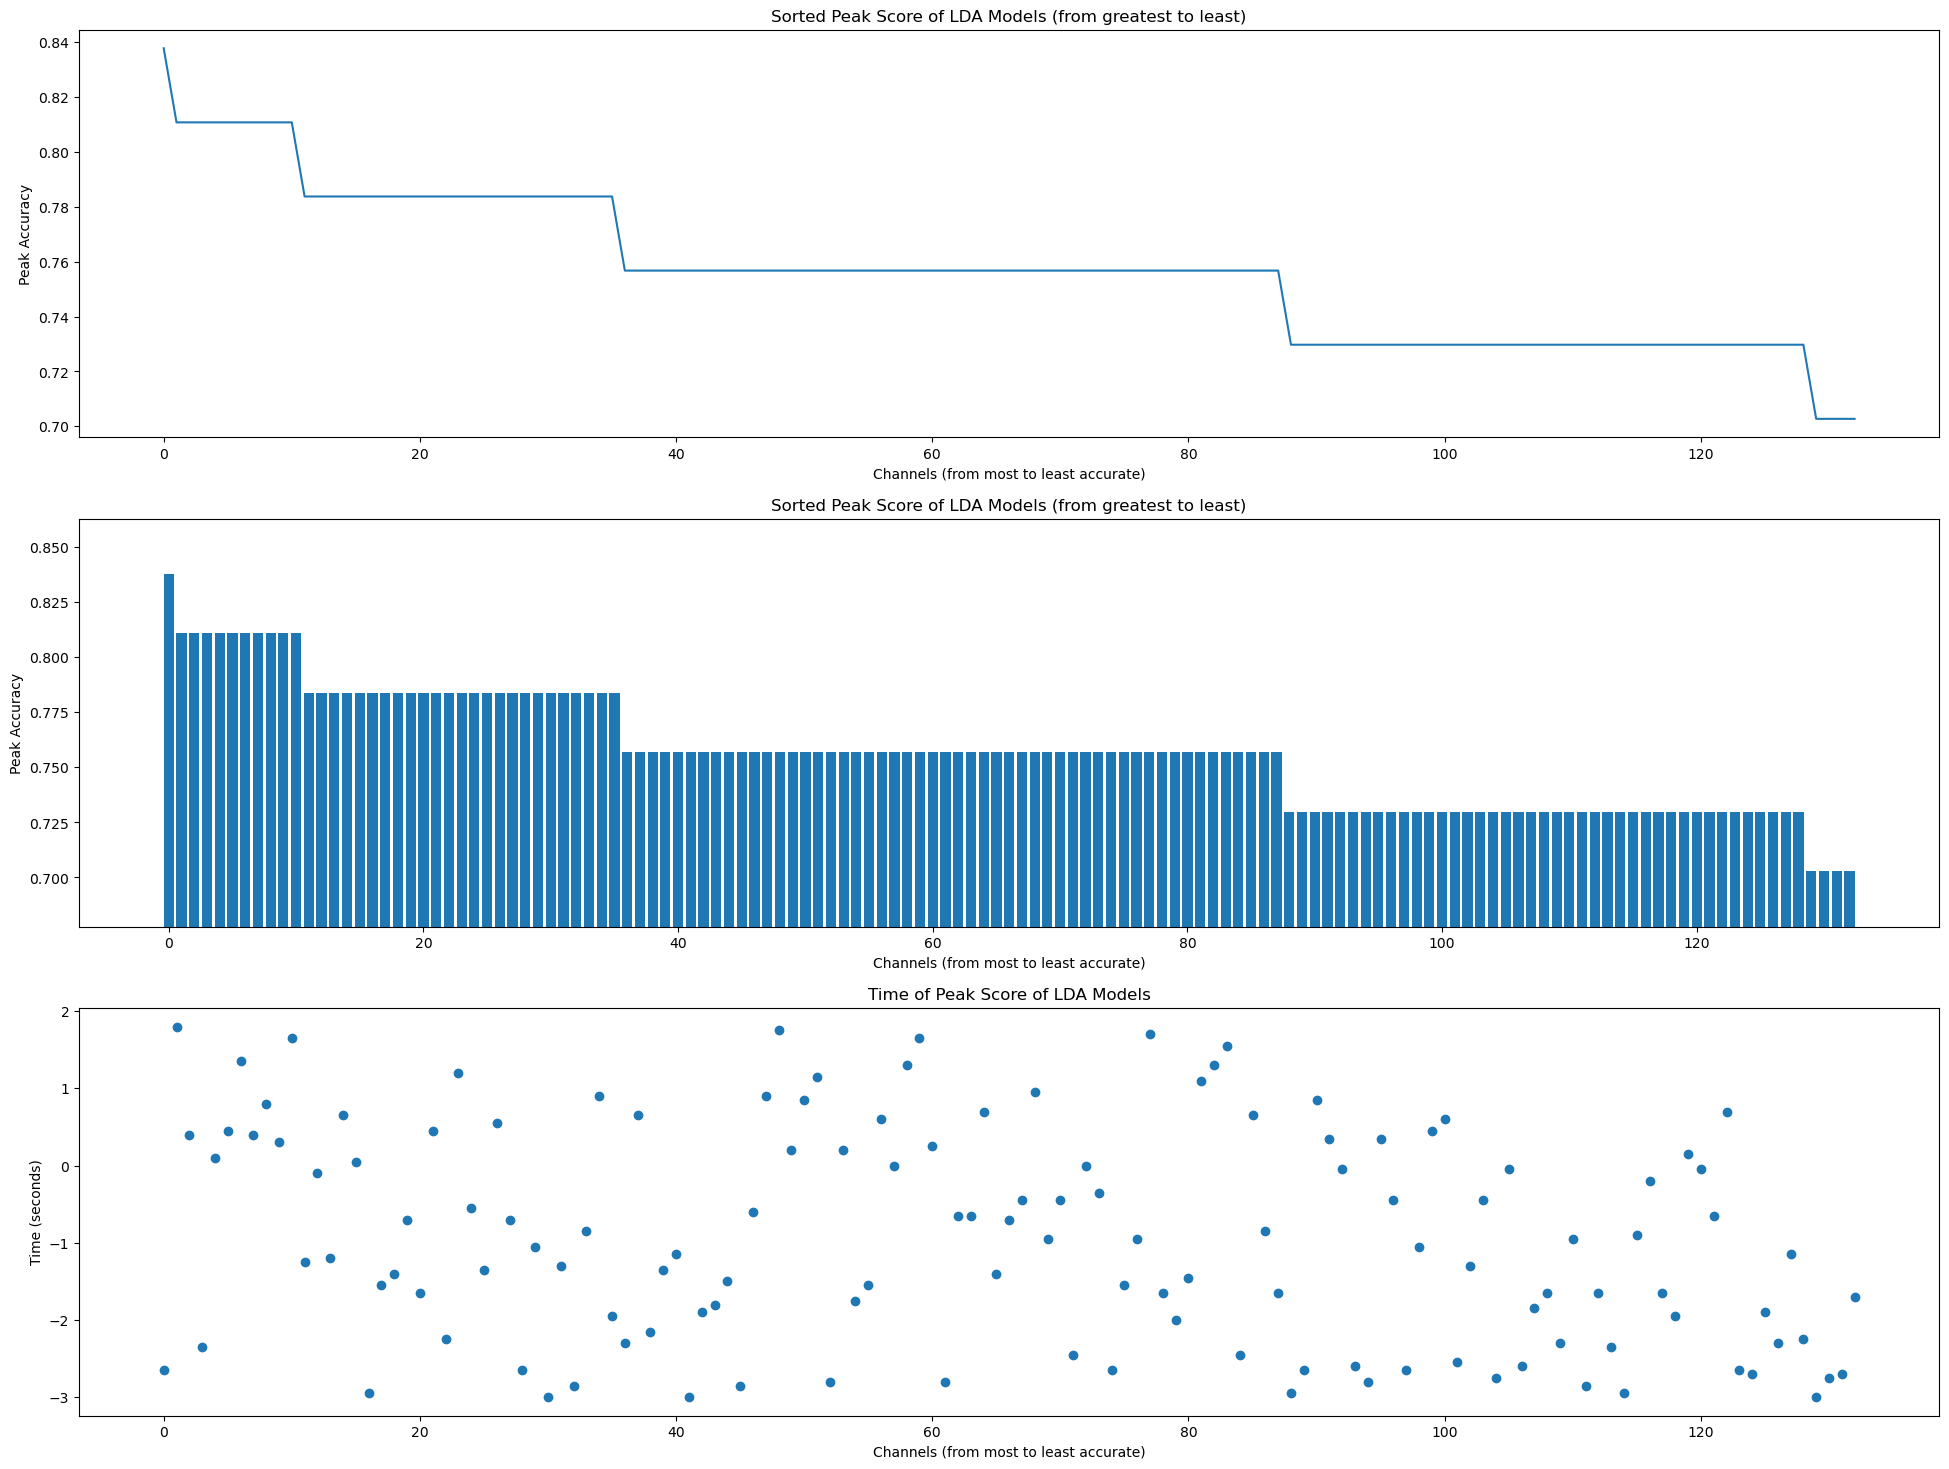

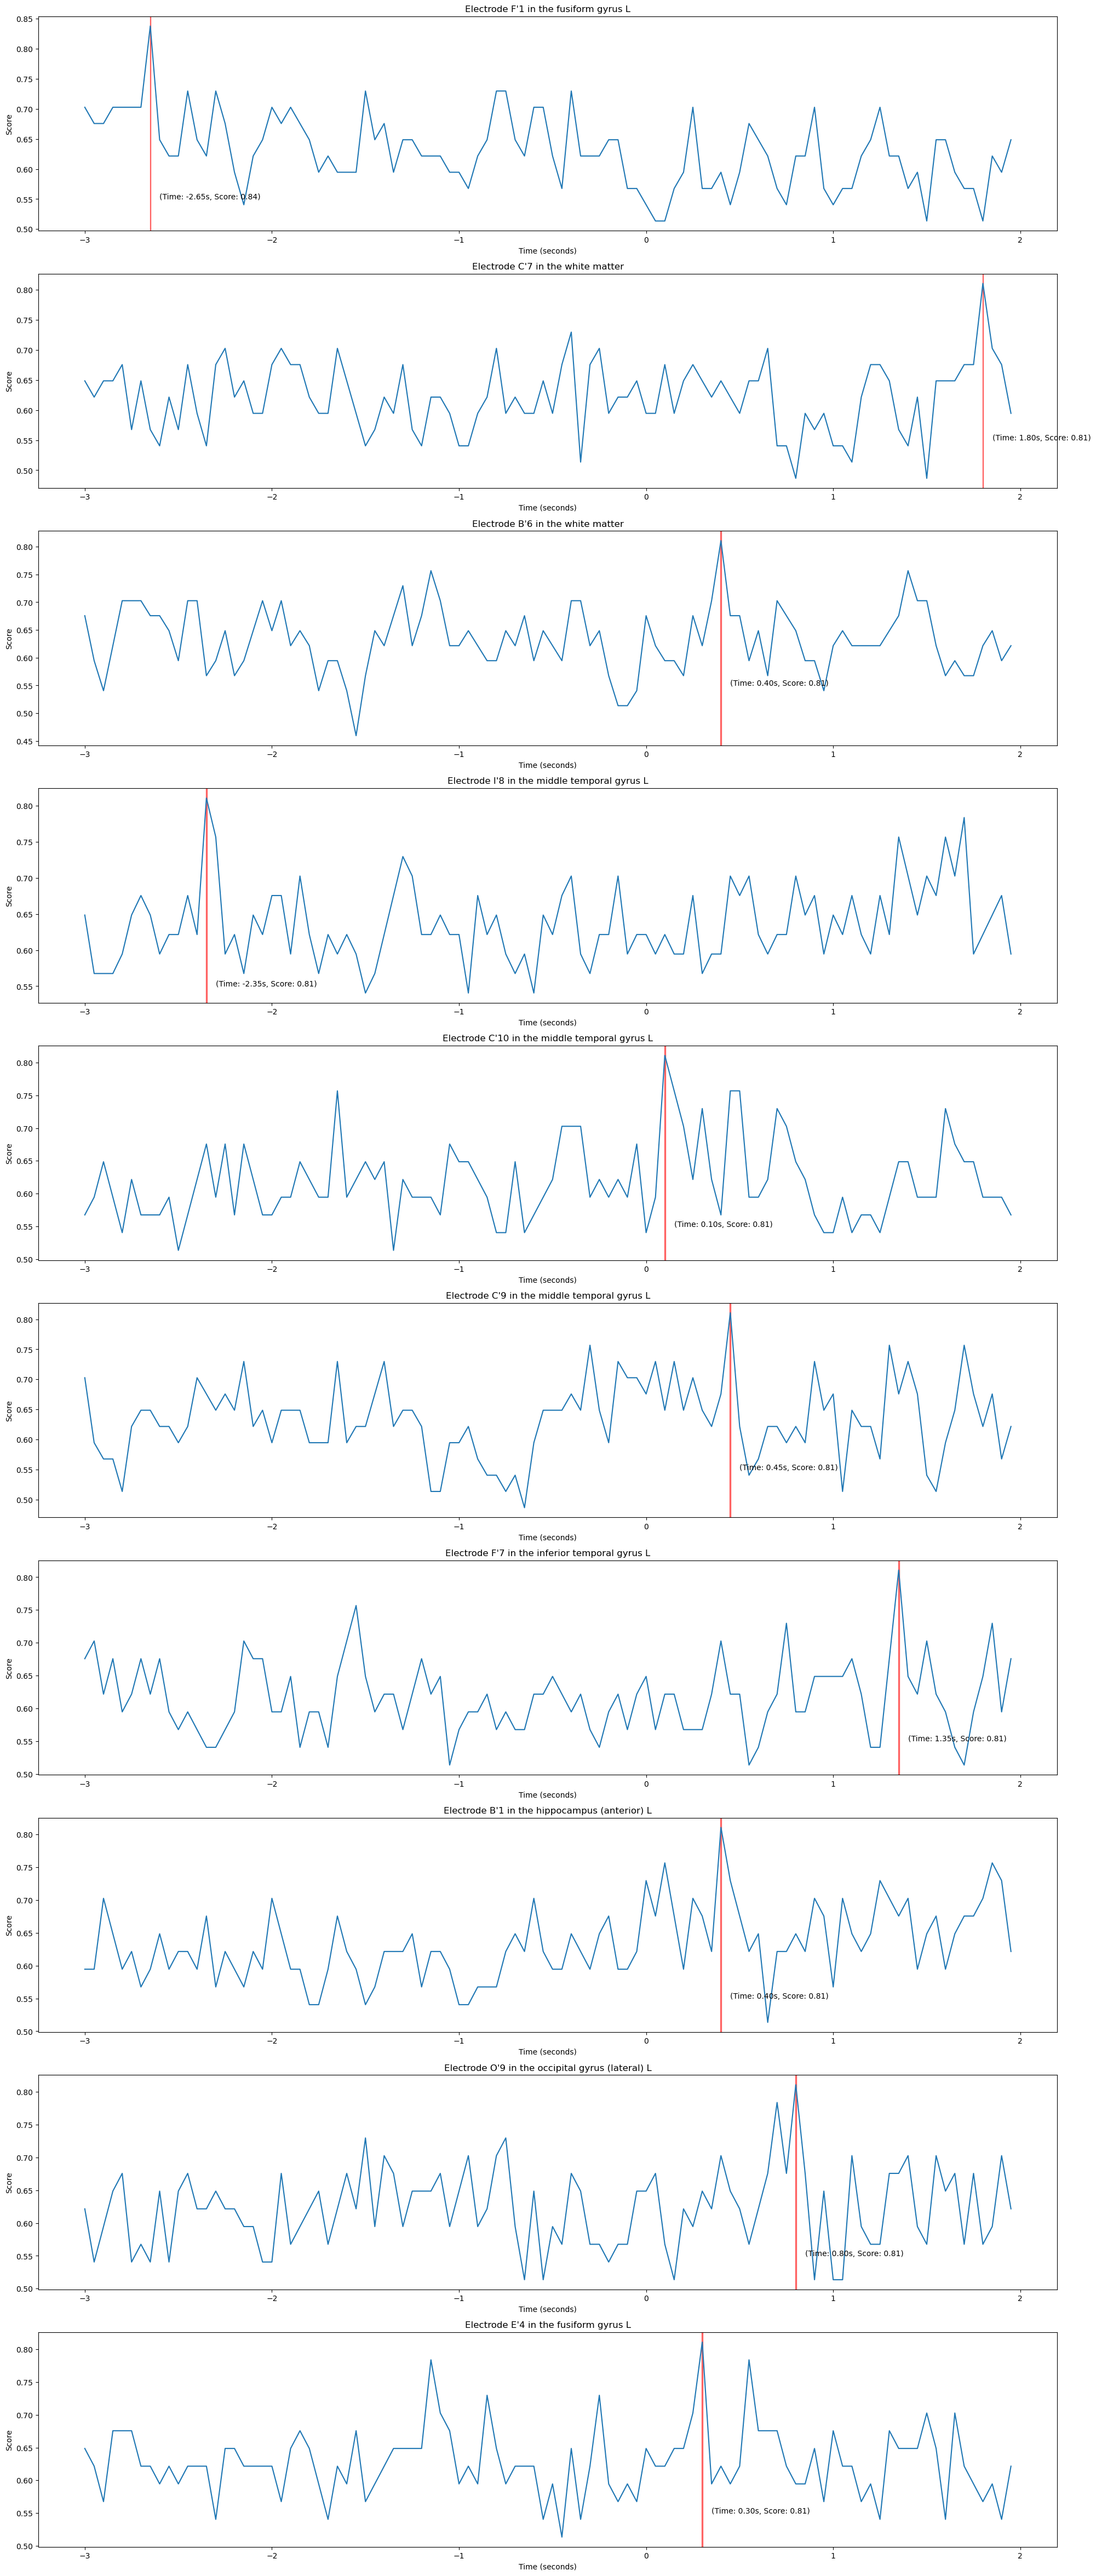

In [32]:
plot_scores(num_channels, best_scores)

<Axes: xlabel='Time (seconds)', ylabel='Frequency (Hz)'>

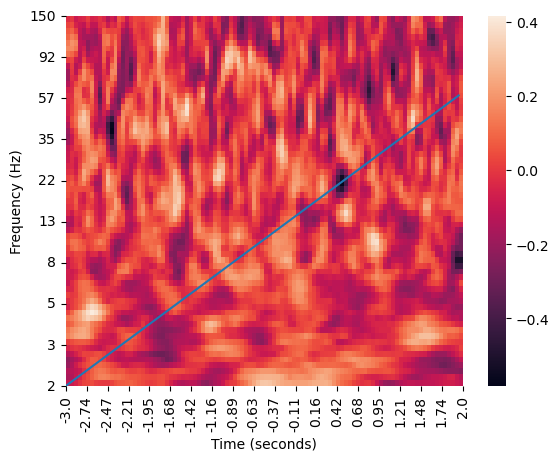

In [239]:
import seaborn as sns

num_x_ticks = 20
num_y_ticks = 10

yticklabels = np.logspace(np.log2(2),np.log2(150),num=num_y_ticks,base=2, dtype=np.int_)
xticklabels = (np.linspace(0, num_timesteps, num=num_x_ticks, dtype=np.float16)/20 - 3)

for i, elem in enumerate(xticklabels):
    xticklabels[i] = round(elem,2)

yticks = np.linspace(0, num_freqs, num_y_ticks)
xticks = np.linspace(0, num_timesteps, num_x_ticks)

ax = sns.heatmap(power_diffs)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)
ax.set(xlabel="Time (seconds)", ylabel="Frequency (Hz)")
ax.axes.invert_yaxis()
sns.lineplot(x=np.arange(0,100), y=1/2*np.arange(0,100))

# Extraneous Code

## Perform sanity check on decision values 

In [ ]:
import math
sanity_check = prob_values[:,:,:,1] - prob_values[:,:,:,0]
for i in range(num_trials):
    if not math.isclose(sanity_check[0,0,i], decision_values[0,0,i],rel_tol=1e-9):
        print('Contradiction in calculated decision values!')

In [ ]:
sanity_check

array([[[-7.19570749e-02, -2.39545076e+00, -1.89675731e+00, ...,
          4.39758592e-01, -2.28695674e-01,  2.47586090e-01],
        [ 8.21020382e-01, -1.29612267e+00, -1.02271754e+00, ...,
          2.04939786e-01, -1.10852494e-01,  6.58514784e-01],
        [ 2.78160702e-01, -2.34801968e+00, -1.68161436e+00, ...,
          4.83847997e-01, -9.70800810e-01, -7.37978971e-01],
        ...,
        [ 2.70316355e-01, -1.55381261e+00,  4.87925465e-01, ...,
          4.19677623e-01, -1.27812912e+00,  2.13753836e-02],
        [ 9.50307947e-01, -1.83296285e+00, -1.29867406e+00, ...,
          1.04006649e+00, -9.78121511e-01, -1.19851038e+00],
        [-1.19988464e+00, -2.69014165e+00, -1.35617031e-01, ...,
          5.76445989e-01, -5.51568712e-01, -1.04718888e+00]],

       [[-9.65207047e-01, -2.13274352e+00, -1.88257460e+00, ...,
          2.20985548e-01, -1.93544558e+00, -4.03260997e-01],
        [ 1.68122369e-01, -1.63749064e+00, -1.30671691e+00, ...,
         -8.32912741e-02, -2.63460619e

In [ ]:
decision_values

array([[[-7.19570749e-02, -2.39545076e+00, -1.89675731e+00, ...,
          4.39758592e-01, -2.28695674e-01,  2.47586090e-01],
        [ 8.21020382e-01, -1.29612267e+00, -1.02271754e+00, ...,
          2.04939786e-01, -1.10852494e-01,  6.58514784e-01],
        [ 2.78160702e-01, -2.34801968e+00, -1.68161436e+00, ...,
          4.83847997e-01, -9.70800810e-01, -7.37978971e-01],
        ...,
        [ 2.70316355e-01, -1.55381261e+00,  4.87925465e-01, ...,
          4.19677623e-01, -1.27812912e+00,  2.13753836e-02],
        [ 9.50307947e-01, -1.83296285e+00, -1.29867406e+00, ...,
          1.04006649e+00, -9.78121511e-01, -1.19851038e+00],
        [-1.19988464e+00, -2.69014165e+00, -1.35617031e-01, ...,
          5.76445989e-01, -5.51568712e-01, -1.04718888e+00]],

       [[-9.65207047e-01, -2.13274352e+00, -1.88257460e+00, ...,
          2.20985548e-01, -1.93544558e+00, -4.03260997e-01],
        [ 1.68122369e-01, -1.63749064e+00, -1.30671691e+00, ...,
         -8.32912741e-02, -2.63460619e

In [ ]:
X = data[:,1,:,1]
lda = LinearDiscriminantAnalysis(solver = 'lsqr', shrinkage='auto')
cv = cross_validate(lda, X,y, cv=5, return_estimator=True) 
test_scores = cv['test_score']
max_index = list(test_scores).index(test_scores.max())
best_lda = cv['estimator'][max_index]
# print(y)
print(best_lda.decision_function(X).shape)
print(best_lda.predict_proba(X).shape)

## Data Visualization

In [ ]:
from matplotlib import cm

# Plot the PSD graph of Subject 06, Trial #1, Channel #1
fig = plt.figure()
ax = plt.axes(projection="3d")

time = np.arange(0,100,1)
wavlet_freqs = np.logspace(np.log2(2),np.log2(150),num=63,base=2)

x1, y1 = np.meshgrid(time,wavlet_freqs)

surf = ax.plot_surface(x1, y1, data[0,0], cmap='inferno')
ax.set_title('Power')
ax.set_ylabel('Time')
ax.set_xlabel('Frequency')

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

## Covariance matrices

In [ ]:
import seaborn as sns

cov = np.cov(mean_accuracies)
sns.heatmap(cov)

In [ ]:
cov_max = np.zeros((num_channels,2))
cov_diag = np.zeros((num_channels))

for channel in range(num_channels):
    # cov_max[channel] = cov[channel].max() # Used to sanity check that cov_diag == cov_max
    cov_temp = cov[channel, np.arange(num_channels) != channel] # Get the entire row 
    cov_max[channel,0] = cov_temp.max()
    cov_max[channel,1] = int(list(cov_temp).index(cov_temp.max())) # Get the corresponding channel that has the highest covariance
    cov_diag[channel] = cov[channel,channel]

In [ ]:
# print(cov_diag)
# print(cov_max)
# print(cov[0,0])

# print(cov_diag==cov_max) # Used to sanity check that cov_diag == cov_max
# print(cov_max/cov_diag)

# print(cov_max[0])

cov_ratio = (cov_max[:,0]/cov_diag) # Get the ratios of the maximum value of the covariance (non-diagonal) to the value of the diagonal
cov_index = []

for i, covariance in enumerate(cov_ratio):
     if covariance > .5:
            cov_index.append(i)

print(cov_index)


In [ ]:
# Prints the mean accuracy vs time graphs of the channels with the highest covariance

fig, axs = plt.subplots(len(cov_index), 1, figsize=(24, 48))

time = np.arange(0, 100, 1)

for i, channel in enumerate(cov_index):
    ax = axs[i]
    ax.plot(time, mean_accuracies[channel])
    ax.set_title('Channel #%i' %(channel + 1))
    ax.set_ylabel('Mean Accuracy')
    ax.set_xlabel('Time')

plt.show()